1.0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0]
Preds:  [0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0] 


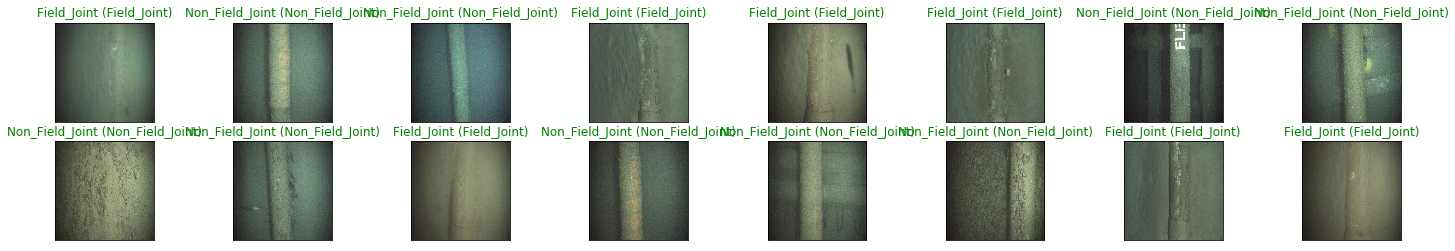

In [9]:
from torchvision import models
import tarfile
import boto3, os
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
import matplotlib.pyplot as plt
import numpy as np
import PIL

from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from collections import OrderedDict

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
batch_size = 16
training_path_test =  'test'
NUM_CLASSES =2
classes = ["Field_Joint", "Non_Field_Joint"]

class Get_data_loader():
    
    def __init__(self, test_batch_size,testing_dir):
        self.batch_size = test_batch_size
        self.testing_dir = testing_dir

    def get_data_loader(self):
        
        data_transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD)
        ])

        dataset = ImageFolderWithPaths(self.testing_dir, data_transform)

        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


#def imshow(img):
#    img = img / 2 + 0.5  # unnormalize
#    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

    
def imshow(img):
    img = img.numpy().transpose((1,2,0)) * STD + MEAN
    plt.imshow(img)  # convert from Tensor image
    
# Visualize Sample Test Results
def Visualize(model, test_loader, batch_size, use_cuda):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels, paths = dataiter.next()
    images.numpy()
    if use_cuda:
        images = images.cuda()
        
    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
        imshow(images.cpu()[idx])
        ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                     color=("green" if preds[idx]==labels[idx].item() else "red"))
    print("Labels: {0}".format(labels.numpy()))
    print("Preds:  {0} ".format(preds))
  

print(torch.__version__)
       

#print(model.cpu().state_dict())
tar = tarfile.open('model.tar.gz', "r:gz")
for member in tar.getmembers():
    if member.name=='model.pth':
        f=tar.extractfile(member)
        model = torch.load(f, map_location='cpu')
if model != None:
    test_loader = Get_data_loader(batch_size, training_path_test).get_data_loader()
    use_cuda = False
    Visualize(model, test_loader, batch_size, use_cuda)




# --------------------Code for accessing s3 nd downloading the model
#bucket = 'perth-sagemaker'
#outputpath='Data_Repository/CathX_Woodside/Models'
#images= "/Images-densenet121-AF3-2019-05-15-03-55-31-852"
#key = outputpath + images + "/output" + "/model.tar.gz"
#filename ="./model.tar.gz"
#s3 = boto3.resource('s3')
#s3.Bucket(bucket).download_file(key, filename)



#----------------------Creating model using saved dictionary-------------------
#model = models.densenet121(pretrained=True)
#model.avgpool = nn.AdaptiveAvgPool2d(1)
#model.classifier = nn.Sequential(OrderedDict([
#    ('fc1', nn.Linear(1024, 256)),
#    ('relu', nn.ReLU()),
#    ('dropout', nn.Dropout(0.2)),
#    ('fc2', nn.Linear(256, NUM_CLASSES))
#    ]))

#tar = tarfile.open('model.tar.gz', "r:gz")
#for member in tar.getmembers():
#    if member.name=='model.pth':
#        f=tar.extractfile(member)
#        pretrained_dict = torch.load(f)
#        model_dict = model.state_dict()
#        model.load_state_dict(model_dict)

       
#-----------------------Code snippet for only loading key value pairs if they exist in the model-------------
#pretrained_dict = ...
#model_dict = model.state_dict()
#pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## 2. overwrite entries in the existing state dict
#model_dict.update(pretrained_dict) 
## 3. load the new state dict
#model.load_state_dict(pretrained_dict)

